# Simulated Annealing Demo

Skrypt przedstawia przykładową implementację algorytmu symulowanego wyżarzania (ang. Simulated Annealing, SA) i jego zastosowanie do rozwiązywania problemu Quadratic Assignment Problem (QAP). Problem jest dokładnie opisany m.in. w pracy Burkarda i innych [1]. Popularne instancje problemu QAP można znaleźć w bibliotece QAPLib [2]. Skrypt skupia się na rozwiązywaniu instancji NUG12 [3], w celu rozwiązywania innych instancji może okazać się konieczna zmiana ustawień parametrów algorytmu.

Literatura:

[1]  Burkard, R., Cela, E., Pardalos, P., Pitsoulis, L., "The Quadratic Assignment Problem", http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.217.1914

[2] QAPLIB, http://anjos.mgi.polymtl.ca/qaplib/

[3] NUG12, http://anjos.mgi.polymtl.ca/qaplib/data.d/nug12.dat

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import urllib.request

%matplotlib inline

In [ ]:
import os, pickle
def serialize(var, folder, var_name):
    with open(os.path.join(folder, var_name + '.pkl'), 'wb') as f:
        pickle.dump(var, f, protocol=2)
        
def unserialize(folder, var_name):
    with open(os.path.join(folder, var_name + '.pkl'), 'rb') as f:
        v = pickle.load(f)
        return v

In [46]:
QAP_INSTANCE_URL = 'http://anjos.mgi.polymtl.ca/qaplib/data.d/nug18.dat'

## Reading input data

In [47]:
qap_instance_file = urllib.request.urlopen(QAP_INSTANCE_URL)

line = qap_instance_file.readline()
n = int(line.decode()[:-1].split()[0])
print('Problem size: %d' % n)

A = np.empty((n, n))
qap_instance_file.readline()
for i in range(n):
    line = qap_instance_file.readline()
    A[i, :] = list(map(int, line.decode()[:-1].split()))
print('Flow matrix:\n', A)

B = np.empty((n, n))
qap_instance_file.readline()
for i in range(n):
    line = qap_instance_file.readline()
    B[i, :] = list(map(int, line.decode()[:-1].split()))
print('Distance matrix:\n', B)

Problem size: 18
Flow matrix:
 [[ 0.  1.  2.  3.  4.  1.  2.  3.  4.  5.  2.  3.  4.  5.  6.  3.  4.  5.]
 [ 1.  0.  1.  2.  3.  2.  1.  2.  3.  4.  3.  2.  3.  4.  5.  4.  3.  4.]
 [ 2.  1.  0.  1.  2.  3.  2.  1.  2.  3.  4.  3.  2.  3.  4.  5.  4.  3.]
 [ 3.  2.  1.  0.  1.  4.  3.  2.  1.  2.  5.  4.  3.  2.  3.  6.  5.  4.]
 [ 4.  3.  2.  1.  0.  5.  4.  3.  2.  1.  6.  5.  4.  3.  2.  7.  6.  5.]
 [ 1.  2.  3.  4.  5.  0.  1.  2.  3.  4.  1.  2.  3.  4.  5.  2.  3.  4.]
 [ 2.  1.  2.  3.  4.  1.  0.  1.  2.  3.  2.  1.  2.  3.  4.  3.  2.  3.]
 [ 3.  2.  1.  2.  3.  2.  1.  0.  1.  2.  3.  2.  1.  2.  3.  4.  3.  2.]
 [ 4.  3.  2.  1.  2.  3.  2.  1.  0.  1.  4.  3.  2.  1.  2.  5.  4.  3.]
 [ 5.  4.  3.  2.  1.  4.  3.  2.  1.  0.  5.  4.  3.  2.  1.  6.  5.  4.]
 [ 2.  3.  4.  5.  6.  1.  2.  3.  4.  5.  0.  1.  2.  3.  4.  1.  2.  3.]
 [ 3.  2.  3.  4.  5.  2.  1.  2.  3.  4.  1.  0.  1.  2.  3.  2.  1.  2.]
 [ 4.  3.  2.  3.  4.  3.  2.  1.  2.  3.  2.  1.  0.  1.  2.  3.  2.

## Objective function

In [4]:
def qap_objective_function(p):
    s = 0.0
    for i in range(n):
        s += (A[i, :] * B[p[i], p]).sum()
    return s

In [5]:
p = [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]
print(qap_objective_function(p), p)

578.0 [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]


## Random Sampling

In [18]:
t0 = time.time()

T = 1000000

permutations = np.empty((T, n), dtype=np.int64)
costs = np.zeros(T)
for i in range(T):
    permutations[i, :] = np.random.permutation(n)
    costs[i] = qap_objective_function(permutations[i, :])

print(time.time() - t0)

p = permutations[costs.argmin(), :]
print(qap_objective_function(p), p)

91.10503506660461
600.0 [ 4  5 11  3  9  6 10  7  1  2  8  0]


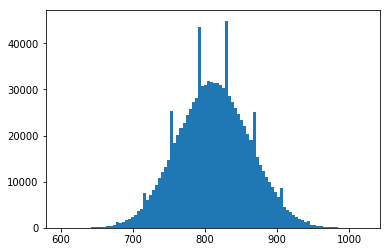

812.042104 49.7998116789


In [19]:
plt.figure()
plt.hist(costs, bins=100)
plt.show()

print(costs.mean(), costs.std())

## Simulated Annealing

In [6]:
def random_neighbor(p, radius):
    q = p.copy()
    for r in range(radius):
        i, j = np.random.choice(n, 2, replace=False)
        q[i], q[j] = q[j], q[i]
    return q

In [7]:
# nug12

T = 500000
radius = 1
alpha = 1.0

t0 = time.time()

p = np.random.permutation(n)
p_cost = qap_objective_function(p)
costs = np.zeros(T)
for t in range(T):
    q = random_neighbor(p, radius)
    q_cost = qap_objective_function(q)
    if(q_cost < p_cost):
        p, p_cost = q, q_cost
    elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
        p, p_cost = q, q_cost
    costs[t] = p_cost

print(time.time() - t0, costs.min())

63.410943269729614 578.0


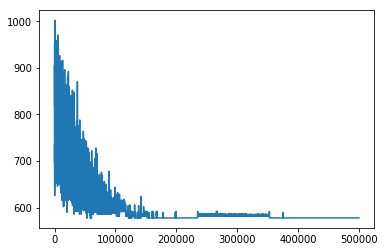

In [23]:
plt.figure()
plt.plot(costs)
plt.show()



86.36687564849854 1610.0


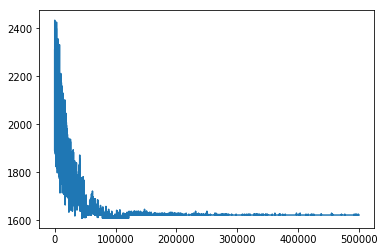

In [28]:
#nug16a
#OPT : 1610

T = 500000
radius = 1
alpha = 1.2

t0 = time.time()

p = np.random.permutation(n)
p_cost = qap_objective_function(p)
costs = np.zeros(T)
for t in range(T):
    q = random_neighbor(p, radius)
    q_cost = qap_objective_function(q)
    if(q_cost < p_cost):
        p, p_cost = q, q_cost
    elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
        p, p_cost = q, q_cost
    costs[t] = p_cost

print(time.time() - t0, costs.min())

plt.figure()
plt.plot(costs)
plt.show()


117.96211814880371 3488.0


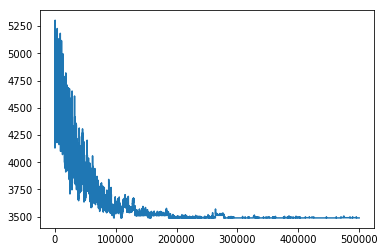

In [35]:
#Nug24
#OPT : 3488

T = 500000
radius = 1
alpha = 0.5

t0 = time.time()

p = np.random.permutation(n)
p_cost = qap_objective_function(p)
costs = np.zeros(T)
for t in range(T):
    q = random_neighbor(p, radius)
    q_cost = qap_objective_function(q)
    if(q_cost < p_cost):
        p, p_cost = q, q_cost
    elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
        p, p_cost = q, q_cost
    costs[t] = p_cost

print(time.time() - t0, costs.min())

plt.figure()
plt.plot(costs)
plt.show()


# Zad1 b)

182.21612215042114
4052.0 [18 16  0  9 14 12 17  8  6 21 20 15  2 19  7  3 10  1 13 22 23 11  5  4]


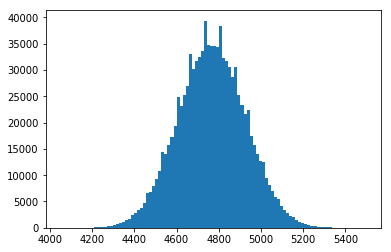

4766.619654 159.288348026


In [16]:
#Nug24
#OPT : 3488

t0 = time.time()

T = 1000000

permutations = np.empty((T, n), dtype=np.int64)
costs = np.zeros(T)
for i in range(T):
    permutations[i, :] = np.random.permutation(n)
    costs[i] = qap_objective_function(permutations[i, :])

print(time.time() - t0)

p = permutations[costs.argmin(), :]
print(qap_objective_function(p), p)

plt.figure()
plt.hist(costs, bins=100)
plt.show()

print(costs.mean(), costs.std())

In [ ]:
# nug24 histogram

results = []
for try_num in range(200):
    
    T = 700000
    radius = 1
    alpha = 1.0

    t0 = time.time()

    p = np.random.permutation(n)
    p_cost = qap_objective_function(p)
    costs = np.zeros(T)
    for t in range(T):
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
        costs[t] = p_cost
    
    results.append(costs.min())
    #print(time.time() - t0, costs.min())

serialize(results, '', 'costs')

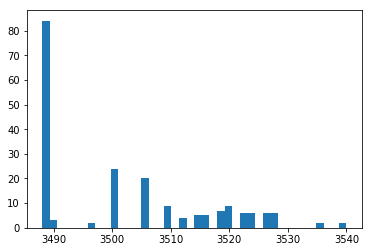

3502.1 14.6256623782


In [33]:
results = np.array(unserialize('', 'costs'))

plt.figure()
plt.hist(results, bins=40)
plt.show()

print(results.mean(), results.std())

# Zad1 c)

63.507718563079834 578.0
79.29378318786621 586.0
94.16027092933655 582.0
63.998526096343994 578.0
78.95283532142639 586.0
92.86897921562195 586.0
63.627583742141724 578.0
78.37388253211975 578.0
93.03063464164734 578.0


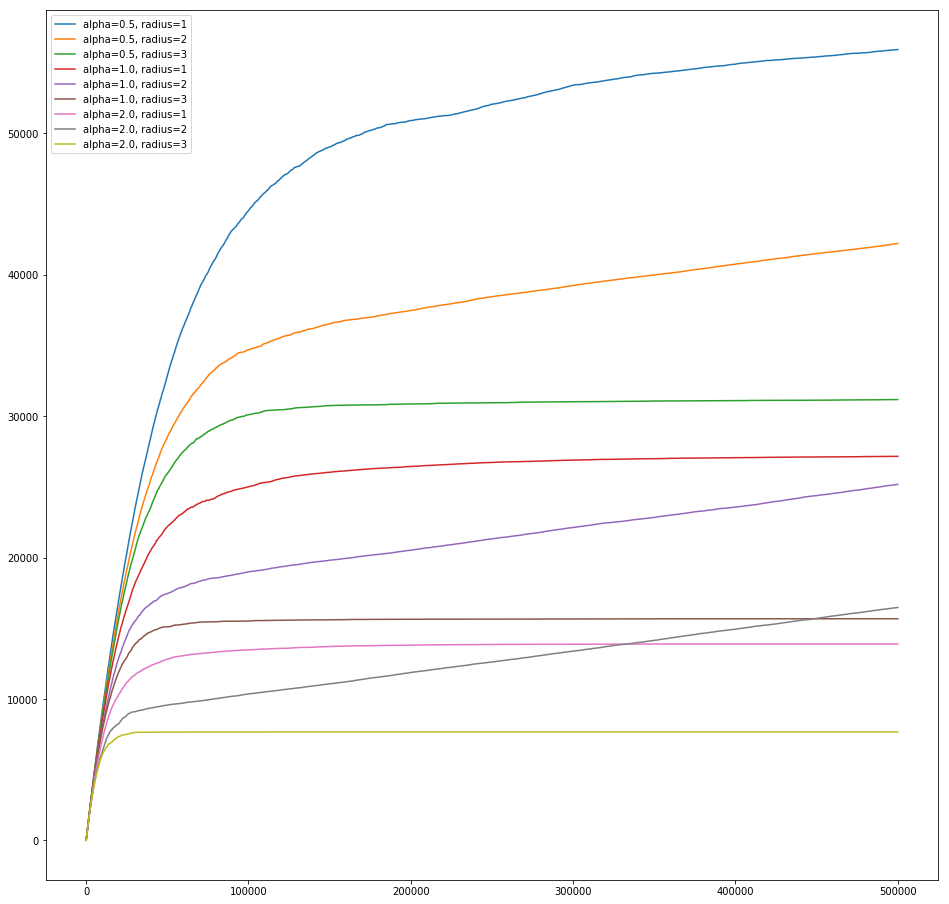

In [45]:
#Nug12
#OPT : 578

alphas = [0.5, 1.0, 2.0]
radiuses = [1, 2, 3]

plt.figure(figsize=(16,16))
for alpha in alphas:
    for radius in radiuses:
        
        T = 500000
        successes = 0
        successes_hist = np.empty(T)
        t0 = time.time()
        
        p = np.random.permutation(n)
        p_cost = qap_objective_function(p)
        costs = np.zeros(T)
        for t in range(T):
            q = random_neighbor(p, radius)
            q_cost = qap_objective_function(q)
            if(q_cost < p_cost):
                successes += 1
                p, p_cost = q, q_cost
            elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
                successes += 1
                p, p_cost = q, q_cost
            costs[t] = p_cost
            successes_hist[t] = successes
        
        plt.plot(successes_hist, label='alpha=' + str(alpha) + ', radius=' + str(radius) )
        print(time.time() - t0, costs.min())

plt.legend()
plt.show()


In [ ]:
#Nug18
#OPT : 1930

alphas = [0.5, 1.0, 2.0]
radiuses = [1, 2, 3]

plt.figure(figsize=(16,16))
for alpha in alphas:
    for radius in radiuses:
        
        T = 500000
        successes = 0
        successes_hist = np.empty(T)
        t0 = time.time()
        
        p = np.random.permutation(n)
        p_cost = qap_objective_function(p)
        costs = np.zeros(T)
        for t in range(T):
            q = random_neighbor(p, radius)
            q_cost = qap_objective_function(q)
            if(q_cost < p_cost):
                successes += 1
                p, p_cost = q, q_cost
            elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
                successes += 1
                p, p_cost = q, q_cost
            costs[t] = p_cost
            successes_hist[t] = successes
        
        plt.plot(successes_hist, label='alpha=' + str(alpha) + ', radius=' + str(radius) )
        print(time.time() - t0, costs.min())

plt.legend()
plt.show()


84.22033023834229 1930.0
98.11603832244873 1944.0
113.25465726852417 1942.0
83.56887245178223 1930.0
98.85842251777649 1976.0
113.4683735370636 1946.0
83.83033657073975 1930.0


# Zad1 d)